In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# 1. Dataset Introduction & Loading

The `quant_finance` dataset is a real-world financial time series from 2024, tracking the hourly market price of the Technology Select Sector SPDR Fund (XLK). The data is sourced using the Yahoo Finance API via the `yfinance` library.

This dataset serves as the financial domain case study in this project.

Financial time series are particularly valuable in anomaly detection research for several reasons:
- They exhibit non-linear, non-stationary behavior with complex trends, volatility clustering, and regime shifts.
- Anomalies in financial data can represent real-world events like earnings reports, geopolitical shocks, or market sentiment changes.
- High-frequency financial data presents challenges for both traditional and modern anomaly detection models, making it a useful for testing and exploring models.

### Basic Information:
- **Granularity:** Hourly
- **Length:** 1,752 records
- **Features:** Univariate, non-polynomial trend

## Loading the Dataset

C:\Users\tangj\AppData\Local\Temp\ipykernel_3636\1050323087.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("XLK", start="2024-01-01", end="2025-01-01", interval="1h")
[*********************100%***********************]  1 of 1 completed


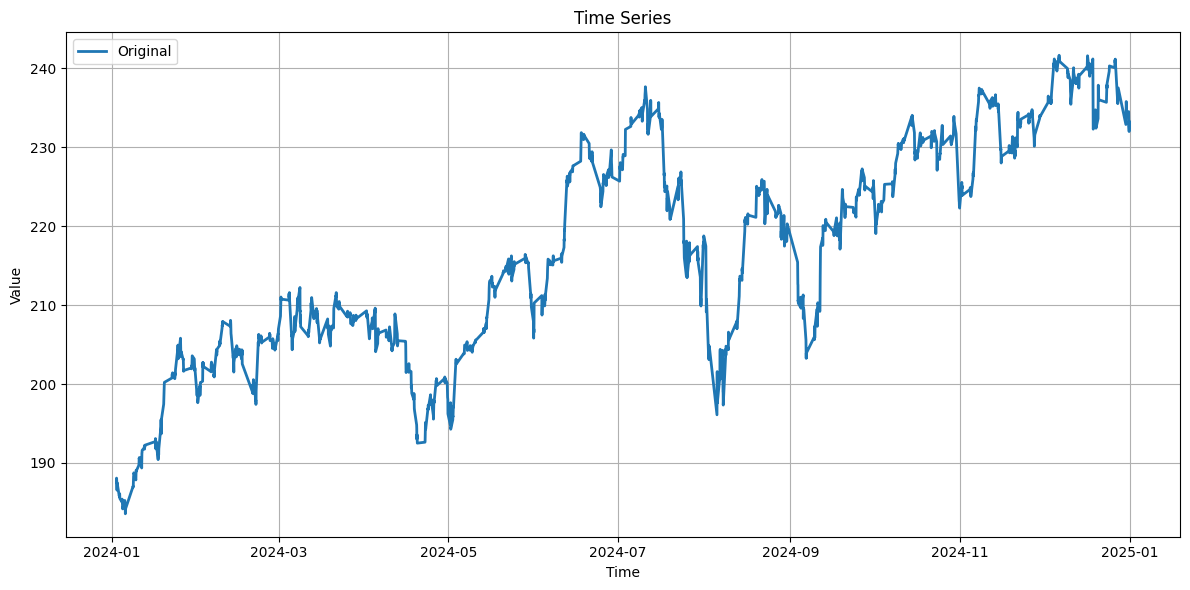

In [3]:
import yfinance as yf
import pandas as pd
from src.visualization.plots import plot_ts

df = yf.download("XLK", start="2024-01-01", end="2025-01-01", interval="1h")

ts = pd.Series(df['Close'].values.flatten(), index=df['Close'].index.tz_localize(None))
plot_ts(ts)

# 2.  Classical Statistical Methods

## STL Decomposition 

To begin, STL is applied using `period=7` (daily seasonality) to separate trend and seasonal components.

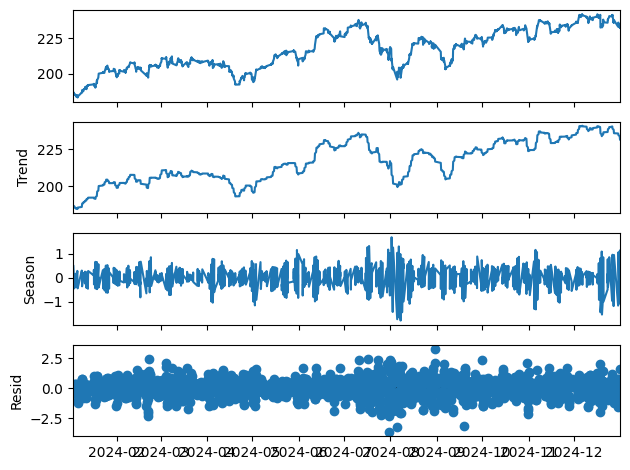

In [4]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=7) # Daily seasonality
stl_result = stl.fit()

_ = stl_result.plot()

An STL decomposition with a seasonal `period=7` was applied to the dataset. As expected for a financial time series, **no meaningful seasonality** was detected, reflecting the absence of consistent short-term cyclic patterns in hourly market prices. The extracted trend component appears **irregular and difficult to model**, which aligns with the inherent unpredictability of financial markets.

The residual component exhibits **heteroskedasticity**, with non-constant variance over time. This is characteristic of financial data, where volatility tends to fluctuate across different market conditions, such as during periods of heightened trading activity, news events, or investor uncertainty.

### Residual Z-scores
Residuals are standardized and plotted for investigation.

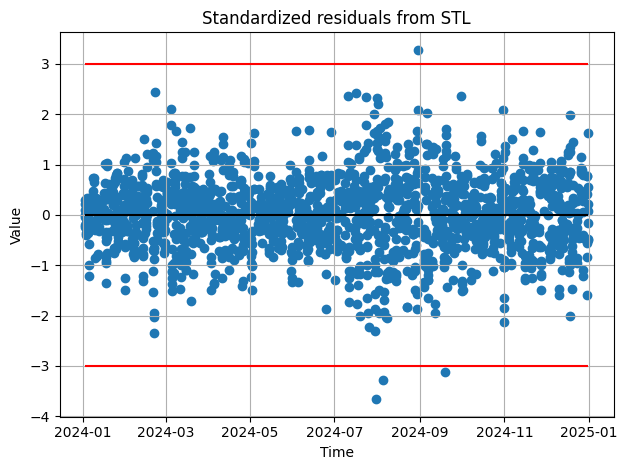

In [5]:
from src.models.preprocessing import standardize_residuals
from src.visualization.plots import plot_scatter

stl_resid = standardize_residuals(pd.Series(stl_result.resid, index=ts.index))
plot_scatter(stl_result.resid, hlines=[-3, 3], title="Standardized residuals from STL")

A total of 4 outliers were identified in the residuals from the STL decomposition, all of which occur between late July and mid-September. This pattern is consistent with financial market behavior where periods of sharp upward or downward movement in stock prices are often accompanied by increased volatility and instability. In particular, when the market experiences a significant decline, it tends to become more reactive and sensitive to new information, leading to larger fluctuations and greater deviation from trend. 

## Rolling Variance & Residuals

A $20$-hour window (~3 trading days) is selected to model weekly trends and short-term noise.

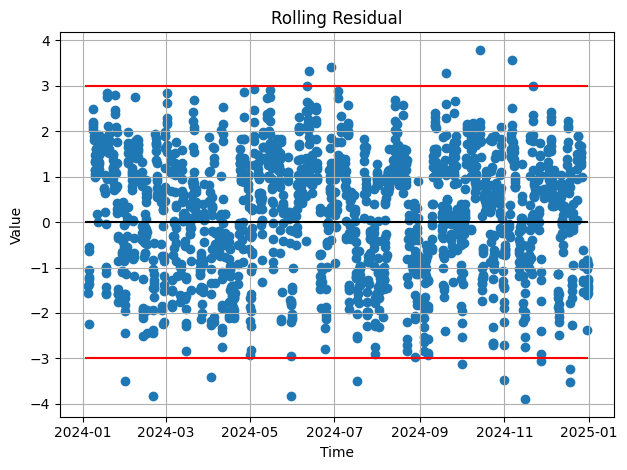

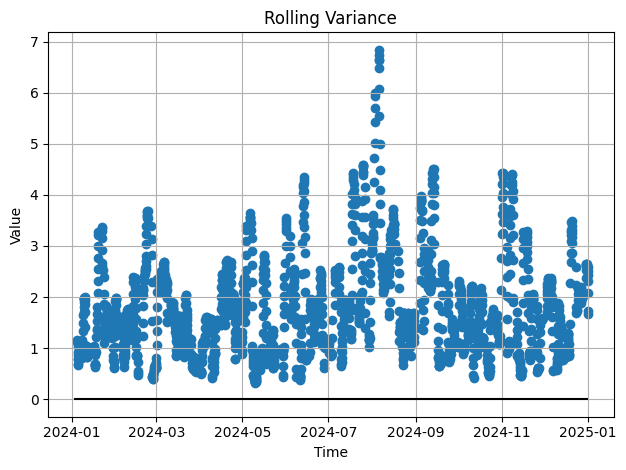

In [6]:
from src.models.statistical.rule_based import rolling_residuals, rolling_variance
from src.visualization.plots import plot_scatter

rolling_var = rolling_variance(ts, window=20)
rolling_resid = rolling_residuals(ts, window=20)

plot_scatter(rolling_resid, title="Rolling Residual", hlines=[-3, 3])
plot_scatter(rolling_var, title="Rolling Variance")

The rolling residuals appear to be evenly distributed around zero, with **no visible trend or drift** over time. The identified outliers in the residuals are also spread across the year without forming distinct clusters, suggesting that the residuals are likely independent and identically distributed (i.i.d.).

In contrast, the rolling variance shows clear signs of **non-constant volatility** throughout the year. A pronounced spike in variance is observed between late July and early August, which aligns with a sharp decline in stock prices in the original time series. This supports the intuition that financial market volatility often increases during sudden price movements. Additionally, high-variance points tend to be surrounded by other high-variance points, indicating **temporal correlation in volatility**.

## Kalman Filters + GARCH

ARCH / GARCH models are fit to the date due the previous hypothesis of heteroskedasticity and temporal correlation in volatility. Kalman filters are used to extract trend.

### Kalman Filter

c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


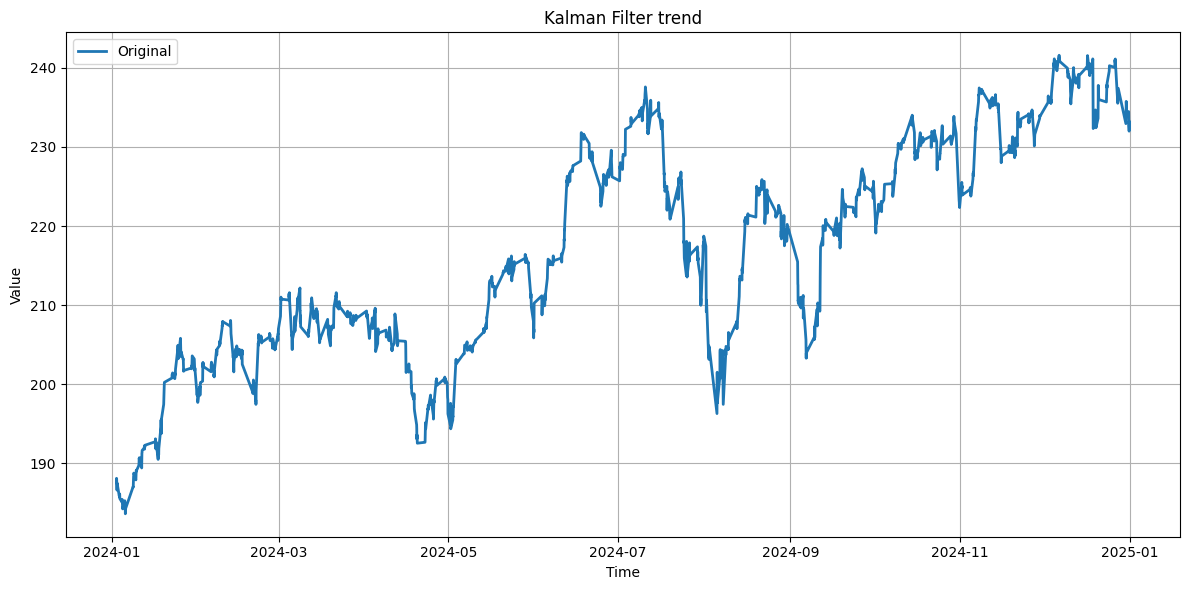

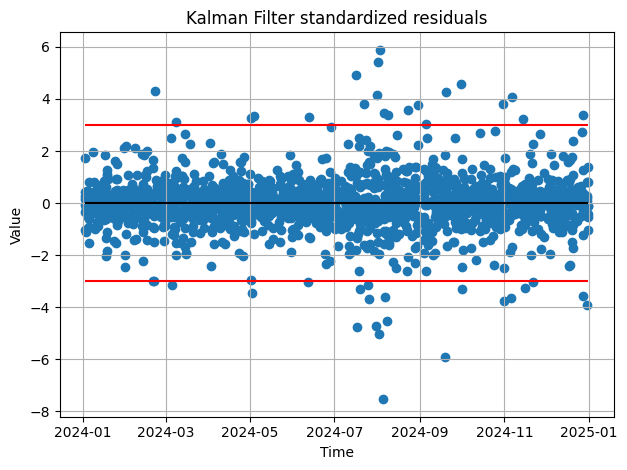

In [7]:
from src.models.statistical.kalman_filters import kalman_local_level
from src.visualization.plots import plot_ts, plot_scatter
from src.models.preprocessing import standardize_residuals

kalman_result = kalman_local_level(ts)
plot_ts(kalman_result['level'], title="Kalman Filter trend")
plot_scatter(standardize_residuals(kalman_result['resid']), hlines=[-3, 3], title="Kalman Filter standardized residuals")

The kalman filter residuals also show non-constant variance where the majority of the outliers lie in months July and August, corresponding to the sudden drop in prices in the original data. 

### GARCH

In [8]:
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(kalman_result['resid'])
print(f"ARCH test p-value: {arch_test[1]}")

ARCH test p-value: 9.162907801219784e-87


The $p$-value is statistically significant, providing strong evidence that the Kalman filter residuals have conditional heteroskedasticity.

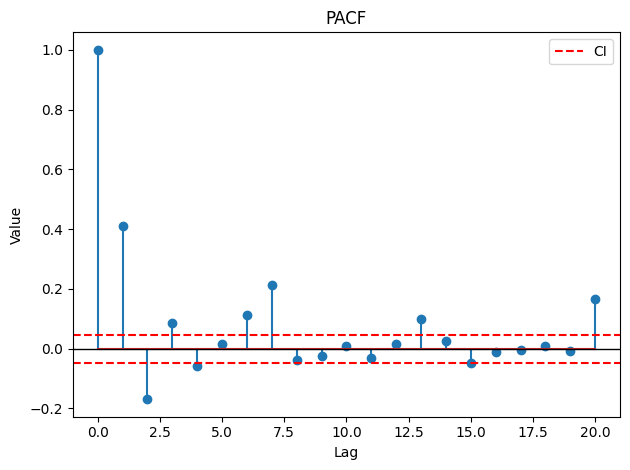

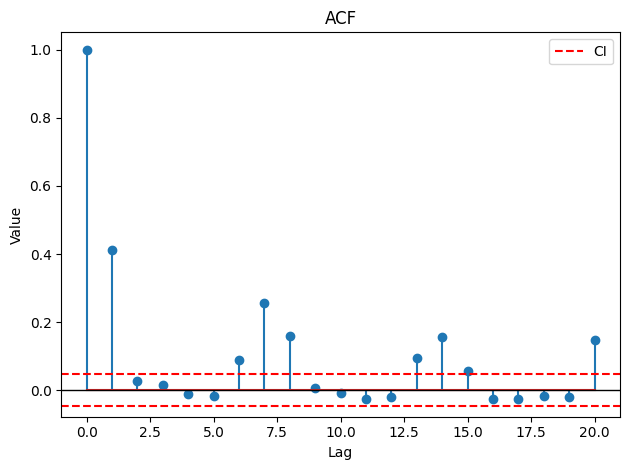

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm
from src.visualization.plots import plot_lag
import numpy as np

nlags = 20
kalman_squared_resid = kalman_result['resid']**2
pacf_vals = pacf(kalman_squared_resid, nlags=nlags)
acf_vals = acf(kalman_squared_resid, nlags=nlags, fft=True)

conf_interval = norm.ppf(1 - 0.05 / 2) / np.sqrt(len(kalman_squared_resid))
plot_lag(pacf_vals, conf_interval, title='PACF')
plot_lag(acf_vals, conf_interval, title='ACF')

The ACF / PACF graphs have significant spikes at lags 1–2, indicating short-term volatility autocorrelation. However, the graphs also depict periodic/cyclic behavior in volatility for larger lags where there’s another statistically significant spike every 5–6 lags. This may be due to market microstructure where volatility could spikes at certain times of day.

This suggest that smaller $(p, q)$ should be used for the GARCH model, a GARCH grid search is conducted to find the best model.

In [10]:
from src.models.statistical.arch_models import garch_grid_search

results_table = garch_grid_search(kalman_result['resid'], max_p=3, max_q=3)
df_results = pd.DataFrame(results_table).sort_values('AIC', na_position='last')

display(df_results[['order', 'AIC', 'BIC']].head(10))


,order,AIC,BIC
7,"(1, 3)",-8833.707687,-8800.896608
6,"(1, 2)",-8804.360784,-8777.018218
5,"(1, 1)",-8751.289345,-8729.415292
4,"(1, 0)",-8701.940653,-8685.535113
11,"(2, 3)",-8693.752056,-8655.472463
10,"(2, 2)",-8680.617480,-8647.806400
9,"(2, 1)",-8660.627601,-8633.285035
8,"(2, 0)",-8644.086545,-8622.212492
15,"(3, 3)",-8635.124472,-8591.376366
14,"(3, 2)",-8620.192878,-8581.913285


Out of the top 10 models sorted by AIC, lower AIC values also result in lower BIC values, thus the first models of $GARCH(1, 3)$ is selected.

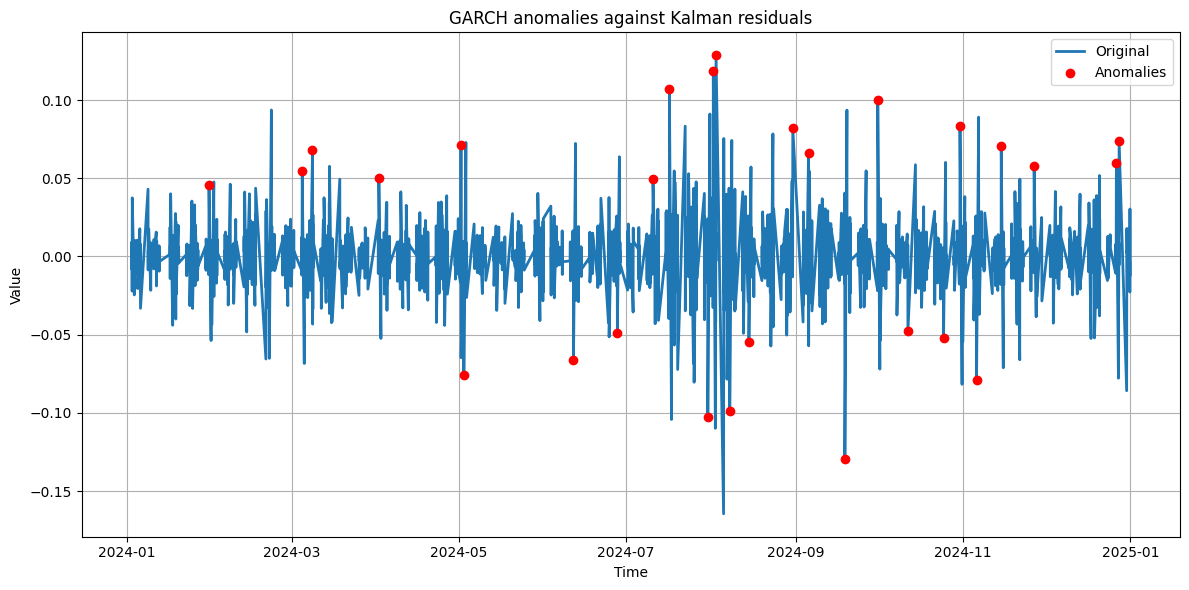

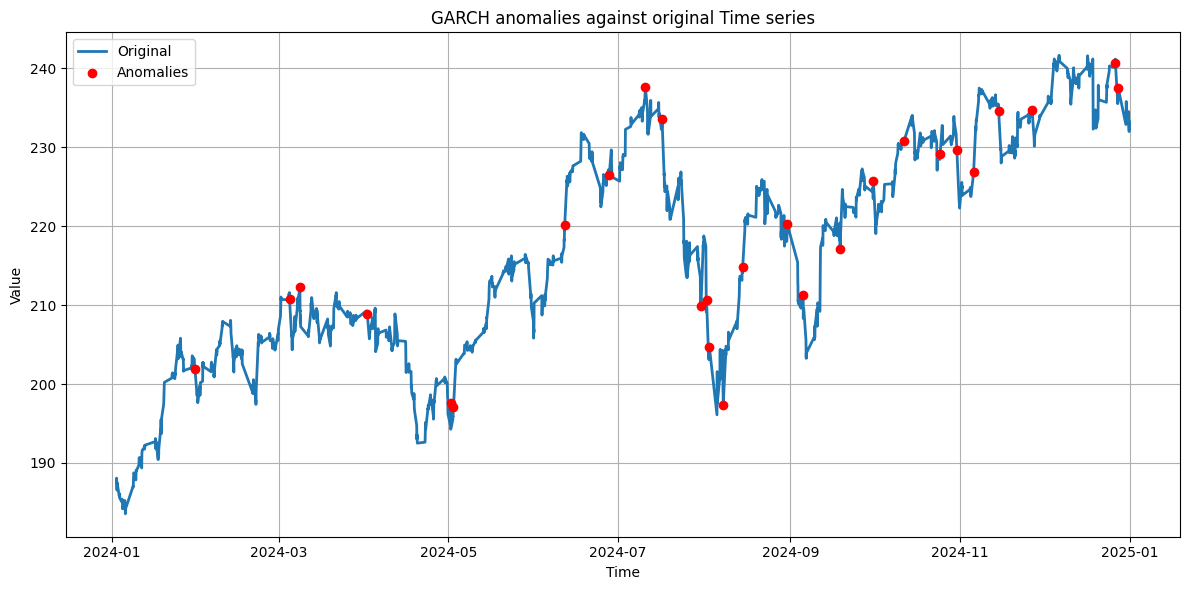

In [13]:
best_garch_model = df_results.iloc[0]

plot_ts(kalman_result['resid'], anom=best_garch_model['anom'], title="GARCH anomalies against Kalman residuals")
plot_ts(ts, anom=best_garch_model['anom'], title="GARCH anomalies against original Time series")

Anomalies identified using the GARCH model are much more evenly distributed throughout the year. This aligns well with expectations as GARCH explicitly models time-varying volatility, which is a common feature for financial time series. As a result, large price movements in volatile periods are not flagged as anomalies, since the volatility is within the model's expectations.

### Across model Anomalies

Since the top 10 models do not differ significantly in terms of AIC and BIC, one may also consider the number of models that marked each point as a prediction anomaly.

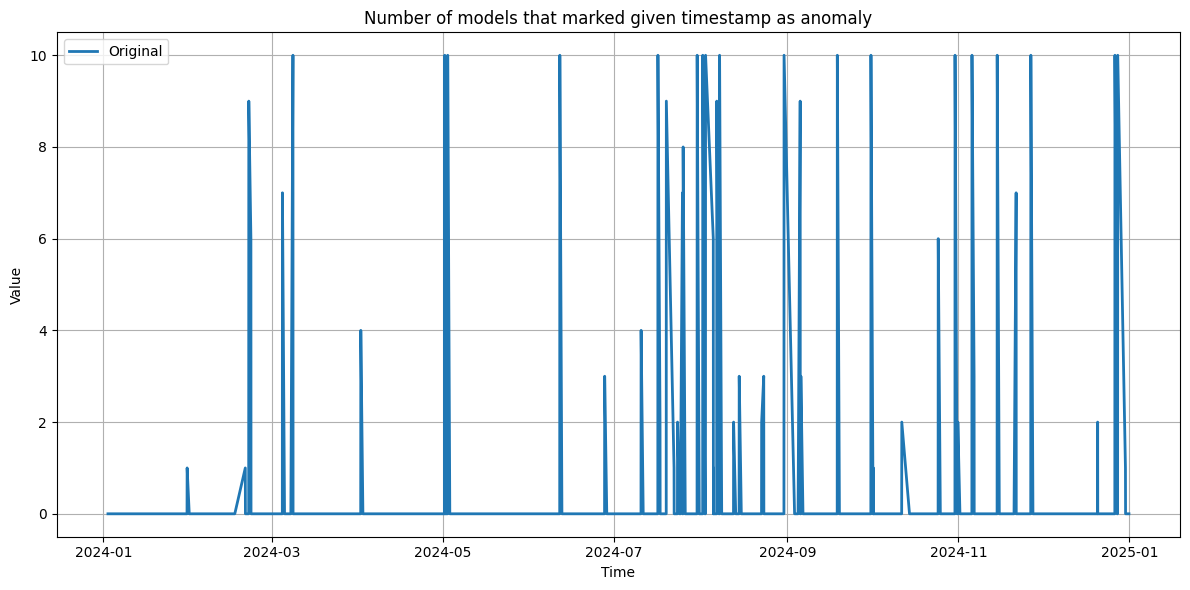

In [14]:
from src.models.statistical.arma_models import count_anoms

anom_counts = count_anoms(df_results[['anom']].head(10))
plot_ts(anom_counts, title='Number of models that marked given timestamp as anomaly')

Results show that the top 10 GARCH models do not differ significantly in terms anomaly detection, and the most anomaly dense period occurs between mid July to mid August. Interesting, this anomaly count also revealed a highly predictable period during the first few days of May and the last week of December (which might be explained by less trading days due to the holiday season). 

# 3 Self-trained Machine Learning models

## LSTM Auto-Encoder

### Short term model
A LSTM model with `window_size=20` (~3 trading days) is fitted to the time series.

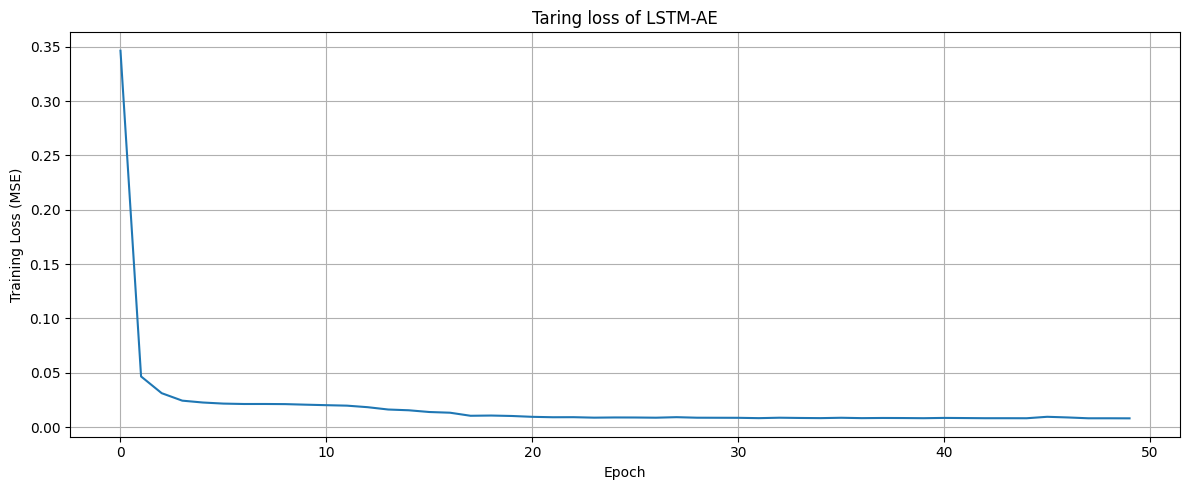

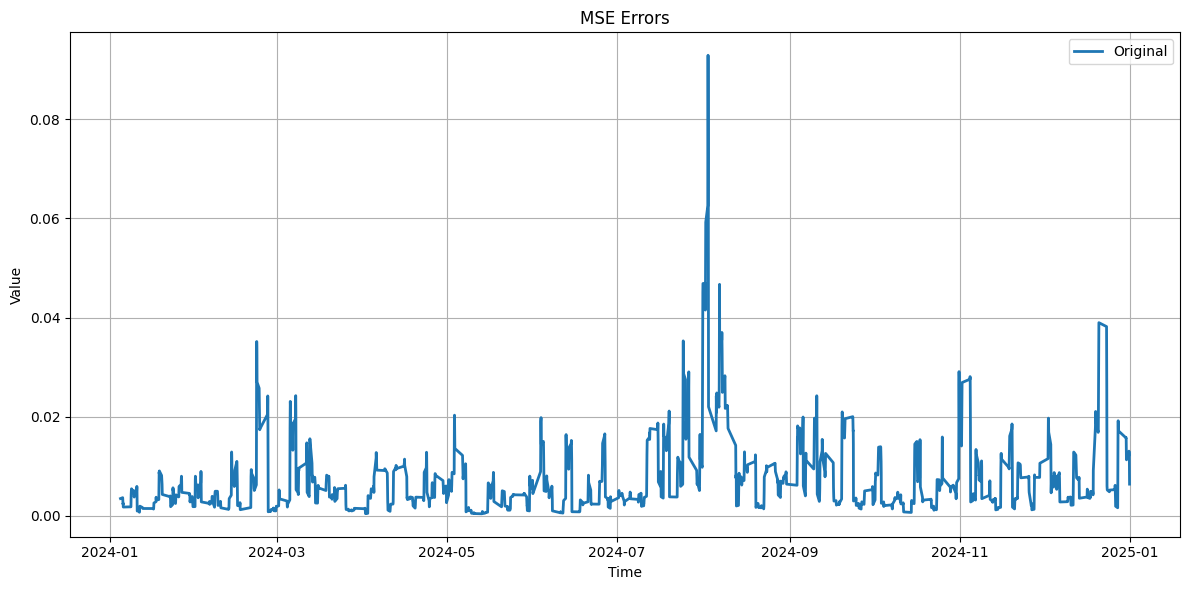

In [15]:
from src.models.self_trained_ml.lstm_ae import model_LSTMAE

mse_LSTM = model_LSTMAE(ts, window_size=20, batch_size=16, hidden_dim=4, latent_dim=4, learning_rate=0.01, epochs=50, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[20:])
plot_ts(errors_ts, title='MSE Errors')

Surprisingly, the LSTM Auto-Encoder converges quite quickly in terms of reconstruction error, with the MSE curve reaching an elbow point around epoch 3–4. This suggests that the model is able to capture the underlying structure of the data with relatively few training iterations.

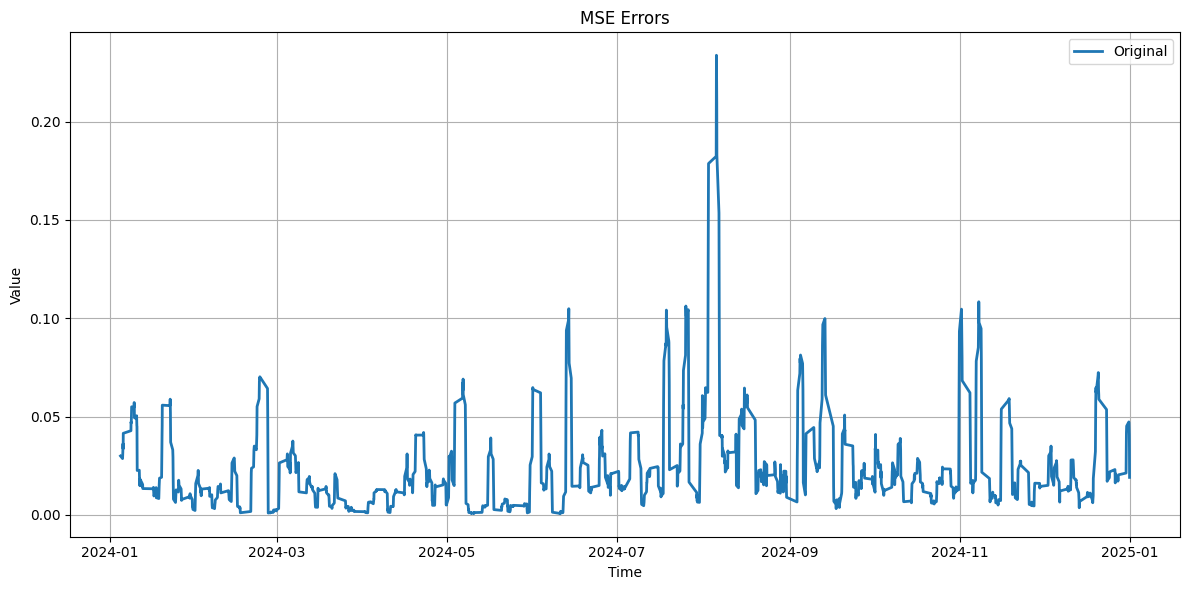

In [17]:
mse_LSTM = model_LSTMAE(ts, window_size=20, batch_size=16, hidden_dim=4, latent_dim=4, learning_rate=0.01, epochs=4)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[20:])
plot_ts(errors_ts, title='MSE Errors')

The peak of the MSE errors occur during early August, corresponding to the drop in market price for the original time series.

### Long term model

A LSTM model with `window_size=100` (~3 weeks) is fitted to the time series.

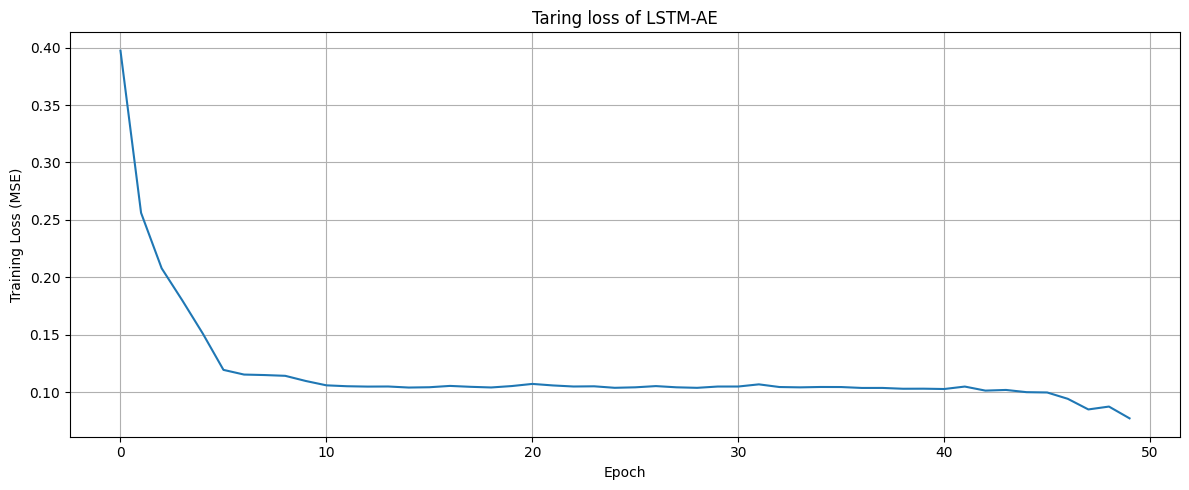

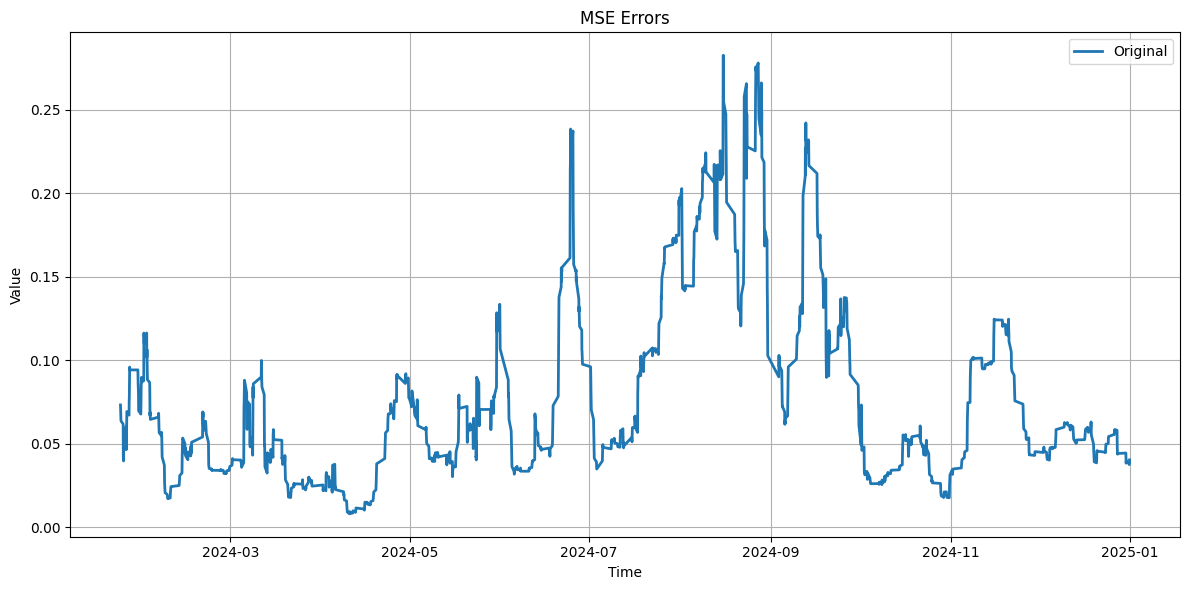

In [19]:
from src.models.self_trained_ml.lstm_ae import model_LSTMAE

mse_LSTM = model_LSTMAE(ts, window_size=100, batch_size=16, hidden_dim=4, latent_dim=4, learning_rate=0.01, epochs=50, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[100:])
plot_ts(errors_ts, title='MSE Errors')

Similarly to the short term model, this LSTM Auto-Encoder converges quite quickly in terms of reconstruction error, with the MSE curve reaching an elbow point around epoch 7-8. However, the overall training loss is significantly higher than the short term model, which is likely explained by a larger inputs (`window_size`) under the same model power (`hidden_dim=4`).

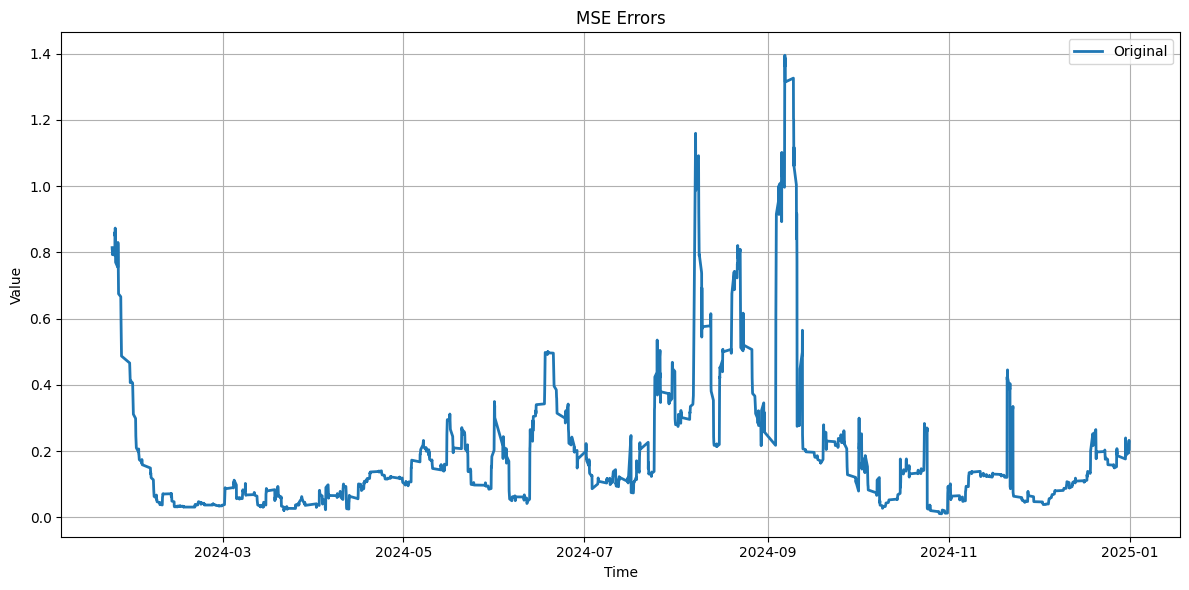

In [20]:
mse_LSTM = model_LSTMAE(ts, window_size=100, batch_size=16, hidden_dim=4, latent_dim=4, learning_rate=0.01, epochs=7)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[100:])
plot_ts(errors_ts, title='MSE Errors')

The peak of the MSE errors occur during early August to early September, corresponding to the drop in market price from mid July to early September in the original time series. Interestingly, this model labeled January with high MSE, such result is not found in any other models in this report.

## Isolation Forest

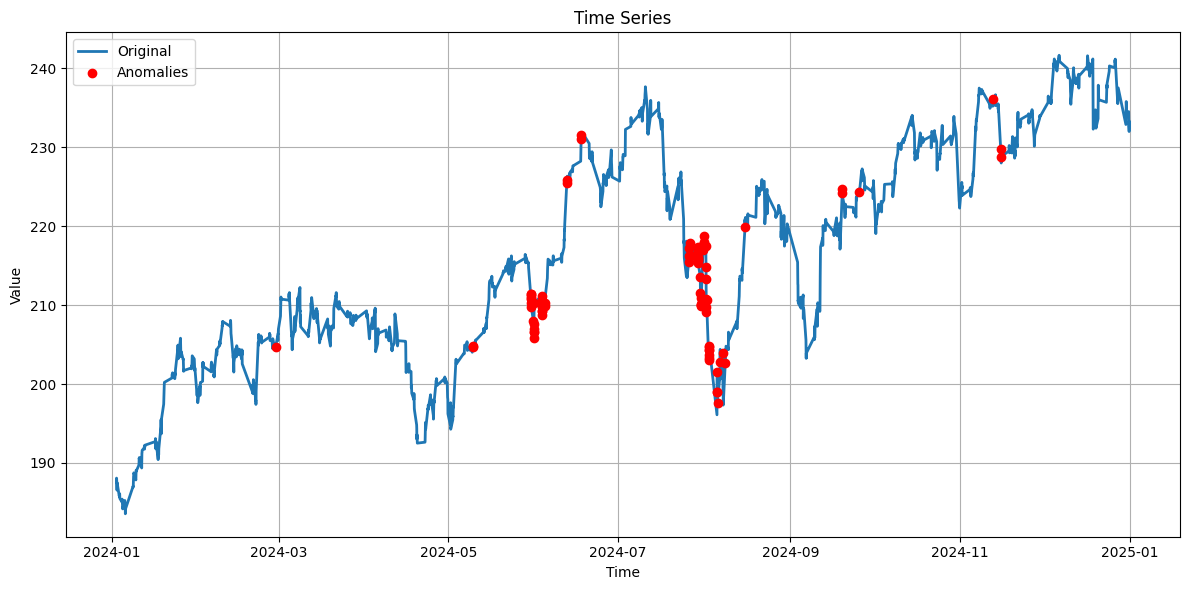

In [23]:
from src.models.self_trained_ml.isolation_forest import model_isolation_forest
import numpy as np

def extract_features(windows) -> pd.DataFrame:
    features = []
    for w in windows:
        w = pd.Series(w)
        returns = w.pct_change().dropna()
        f = {
            'mean': w.mean(),
            'std': w.std(),
            'min': w.min(),
            'max': w.max(),
            'skew': w.skew(),
            'kurt': w.kurt(),
            'slope': np.polyfit(np.arange(len(w)), w.values, 1)[0],

            # Finance Features
            'mean_return': returns.mean(),
            'volatility': returns.std(),
            'max_drawdown': (w / w.cummax() - 1).min(),  
            'sharpe_ratio': returns.mean() / (returns.std() + 1e-9), 
            'return_skew': returns.skew(),
            'return_kurt': returns.kurt(),
            'autocorr_1': returns.autocorr(lag=1),
        }
        features.append(f)
    return pd.DataFrame(features)

if_results = model_isolation_forest(ts, extract_features=extract_features, window_size=35)
plot_ts(ts, anom=if_results['anomaly'])


The anomalies identified by the Isolation Forest show a clear clustering in late July to early August, coinciding with a major market drop. A second, smaller cluster appears from late May to early June, which also aligns with a sharp decline in the market.

These results suggest that, with the current feature set, the Isolation Forest is particularly effective at detecting periods of market downturn and heightened volatility. Its sensitivity to changes in data distribution makes it well-suited for identifying such structural shifts in financial time series.

# 4 Pretrained Models

## Prophet

c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
14:48:29 - cmdstanpy - INFO - Chain [1] start processing
14:48:31 - cmdstanpy - INFO - Chain [1] done processing


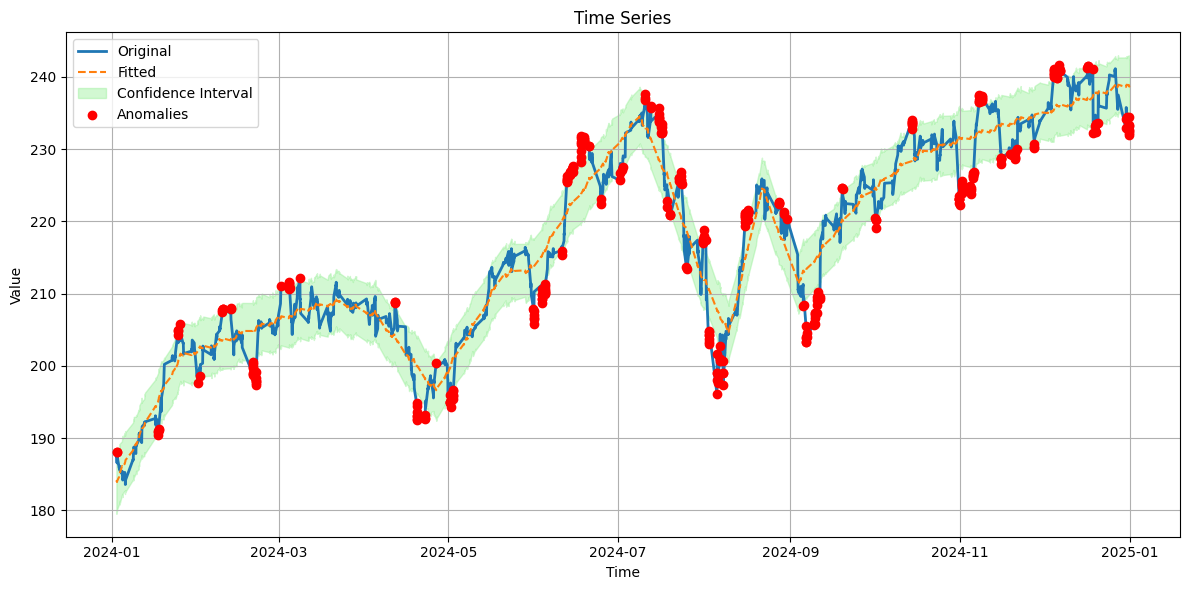

In [24]:
from prophet import Prophet
from src.visualization.plots import plot_ts

prophet_df = pd.DataFrame({
    'ds': ts.index,  
    'y': ts.values 
})

model = Prophet()
model.fit(prophet_df)

prophet_pred = model.predict(prophet_df[['ds']].copy())

prophet_anom = (prophet_df['y'] < prophet_pred['yhat_lower']) | (prophet_df['y'] > prophet_pred['yhat_upper'])
prophet_anom = pd.Series(prophet_anom.values, index=ts.index)

prophet_CI = prophet_pred[['yhat_lower', 'yhat_upper']].copy()
prophet_CI.index = ts.index

plot_ts(ts, pd.Series(prophet_pred['yhat'].values, index=ts.index), CI=prophet_CI, anom=prophet_anom)

Prophet appears to flag many **local maxima and minima** as prediction anomalies, indicating that it fits a relatively smooth trend through the data and has narrow confidence intervals. As a result, local peaks and troughs that deviate slightly from the smoothed trend often fall outside the predicted range and are  identified as anomalies.

### Z-scores

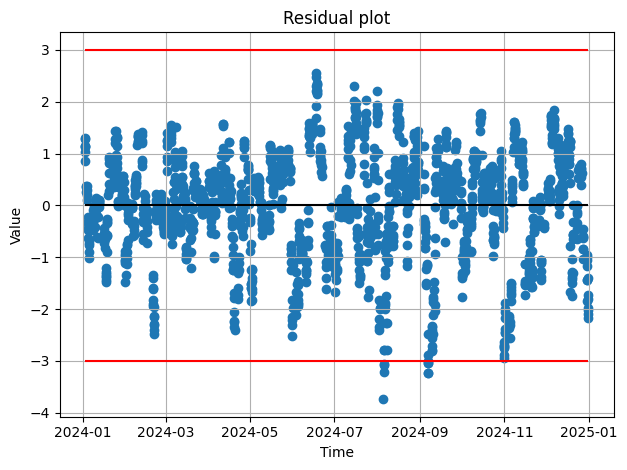

In [25]:
from src.visualization.plots import plot_scatter
from src.models.preprocessing import standardize_residuals

prophet_resid = standardize_residuals(pd.Series(prophet_df['y'].values - prophet_pred['yhat'].values, index=ts.index))
plot_scatter(prophet_resid, hlines=[-3, 3])

The Prophet residual plot does not seem independent and identically distribute (i.i.d.), where large residuals tend to be surrounded buy other large residuals indicating **temporal correlation in residuals**.

The identified residual outliers occur at early August and early September, aligning with the market drop in the original dataset.

# 4. Summary & Comparisons 

The `quant_finance` dataset captures real-world stock market behavior, and as such, it contains **no ground-truth labels** for anomalies. Instead, anomaly detection is based on model interpretations of abnormal behavior within the time series.

Despite this, most models **consistently identified** the mid-July to early September period as anomalous, corresponding to a sharp market decline. This consensus suggests that this period reflects a meaningful structural change or volatility spike in the underlying data.

|Model|Marked July–September as Anomalous | Marked Other Times as Anomalous|
|-------|-------------------------------|------------------|
|STL + Z-scores| Partially | No |
|Rolling residuals| Partially | Yes |
|Rolling variance| Yes| No |
|Kalman filter + GARCH | Partially | Yes |
|LSTM-AE (short term)| Yes | No |
|LSTM-AE (long term)| Yes | Sometimes |
|Isolation forest| Yes | Sometimes |
|Prophet | Yes | Yes |